In [126]:
# Importing libraries and dependencies
import logging
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sklearn

# Configure logging
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(), logging.FileHandler('package_id_log')])

def load_data_OpenDataTO(package_id_log):
    """
    Load a dataset from the Toronto Open Data API.

    Parameters:
    - package_id (str): The ID of the package containing the dataset in a dict {}.

    Returns:
    - pd.DataFrame or None: A DataFrame containing the dataset if successfully loaded, 
                            or None if an error occurred.
    """
    # Define the base URL for the Toronto Open Data API
    base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

    # Define the URL to access the metadata of a package
    metadata_url = base_url + "/api/3/action/package_show"

    # Set the parameters to retrieve information about the desired package
    params = {"id": package_id_log}
         
    # Send a GET request to retrieve metadata about the package
    response = requests.get(metadata_url, params=params)

    # Check if the GET request was successful
    if response.status_code == 200:
        # Parse the JSON response
        package_info = response.json()
        
        # Extract information about the resources in the package
        resources = package_info['result']['resources']
        
        # Look for a JSON resource and load its data using CKAN API
        for resource in resources:
            if resource['format'].lower() == 'json':
                data_url = base_url + "/api/3/action/datastore_search"
                params = {"id": resource["id"]}
                filters = {
                    #"ARREST_YEAR": [2014,2015,2016,2017,2018, 2019, 2020, 2021, 2022],
                    "DIVISION": "D11"  # Filter for DIVISION(Geographic division where crime took place)
                }

                all_records = []
                limit = 5000  # Number of records to retrieve per request
                
                # Paginate through the data until all records are retrieved
                offset = 0
                while True:
                    params["offset"] = offset
                    params["limit"] = limit
                    params["filters"] = json.dumps(filters)  # Encode filters as JSON string
                    response = requests.get(data_url, params=params)
                    response_json = response.json()
                    if "result" not in response_json or not response_json["success"]:
                        logging.error("Error retrieving data from the API.")
                        return None
                    
                    resource_search_data = response_json["result"]
                    records = resource_search_data.get("records", [])
                    all_records.extend(records)
                    
                    # Check if we have fetched all records
                    if len(records) < limit:
                        break  # Break the loop if all records have been retrieved
                    
                    offset += limit  # Move to the next page
                
                df = pd.DataFrame(all_records)
                logging.info("Toronto Open DataFrame created successfully using CKAN API parameters.")
                return df
        else:
            logging.warning("No JSON resource found in the package.")
            return None
            
    else:
        logging.error("Failed to retrieve metadata from the API.")
        return None

# Load the Annual Police Report data into the DataFrame
    
package_id = "police-annual-statistical-report-arrested-and-charged-persons"

annual_police_report = load_data_OpenDataTO(package_id)
if annual_police_report is not None:
    annual_police_report.head()
else:
    logging.error("Failed to load the dataset.")
annual_police_report.head()

INFO:root:Toronto Open DataFrame created successfully using CKAN API parameters.


,_id,ARREST_YEAR,DIVISION,HOOD_158,NEIGHBOURHOOD_158,SEX,AGE_COHORT,AGE_GROUP,CATEGORY,SUBTYPE,ARREST_COUNT
0,17,2021,D11,111,Rockcliffe-Smythe (111),Male,35 to 44,Adult,Crimes Against the Person,Assaults,2
1,50,2014,D11,81,Trinity-Bellwoods (81),Male,18 to 24,Adult,Crimes Against the Person,Assaults,1
2,63,2014,D11,85,South Parkdale (85),Male,35 to 44,Adult,Crimes Against the Person,Assaults,3
3,75,2020,D11,171,Junction-Wallace Emerson (171),Female,25 to 34,Adult,Crimes Against the Person,Assaults,3
4,100,2015,D11,171,Junction-Wallace Emerson (171),Male,25 to 34,Adult,Crimes Against Property,Theft Under $5000,8


In [127]:
#converting column names to lowercase
def rename_data(annual_police_report):
  if annual_police_report is None:
    raise ValueError('No columns found')
  report=annual_police_report.rename(columns=str.lower)
  return report
rename_data(annual_police_report)
annual_police_report=rename_data(annual_police_report)
annual_police_report.head()

,_id,arrest_year,division,hood_158,neighbourhood_158,sex,age_cohort,age_group,category,subtype,arrest_count
0,17,2021,D11,111,Rockcliffe-Smythe (111),Male,35 to 44,Adult,Crimes Against the Person,Assaults,2
1,50,2014,D11,81,Trinity-Bellwoods (81),Male,18 to 24,Adult,Crimes Against the Person,Assaults,1
2,63,2014,D11,85,South Parkdale (85),Male,35 to 44,Adult,Crimes Against the Person,Assaults,3
3,75,2020,D11,171,Junction-Wallace Emerson (171),Female,25 to 34,Adult,Crimes Against the Person,Assaults,3
4,100,2015,D11,171,Junction-Wallace Emerson (171),Male,25 to 34,Adult,Crimes Against Property,Theft Under $5000,8


In [128]:
annual_police_report.shape

(7621, 11)

In [129]:
annual_police_report["age_cohort"] = annual_police_report["age_cohort"].astype("category")
annual_police_report["age_cohort"].dtype


CategoricalDtype(categories=['18 to 24', '25 to 34', '35 to 44', '45 to 54', '55 to 64',
                  '65+', '<18', 'Unknown'],
, ordered=False, categories_dtype=object)

In [130]:
def total_only_f(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    # Create a dataframe where 'category' is Total Arrests only 
    total_data = dataframe[dataframe['category'] == 'Total Arrests']

    return total_data

In [131]:
def by_year_f(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Group rows by year
    by_group = dataframe.groupby(['arrest_year'])

    # Add up all Total Arrests for each year
    year_sum = by_group.agg(arrest_count = ('arrest_count', 'sum'))

    return year_sum

In [132]:
total_df = total_only_f(annual_police_report)
by_year = by_year_f(total_df)
by_year

,arrest_count
arrest_year,
2014,1577
2015,1418
2016,1487
2017,1405
2018,1216
2019,1242
2020,1000
2021,943
2022,1127


In [133]:
def plotby_year_f(data: pd.DataFrame,column):
    fig,ax = plt.subplots()
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)   
    offset=0.7
    count = ax.bar(data.index, data[column], width=offset)
    ax.set_title('(Division-D11) Toronto \n ARRESTS COUNT BY YEAR', fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Counts')

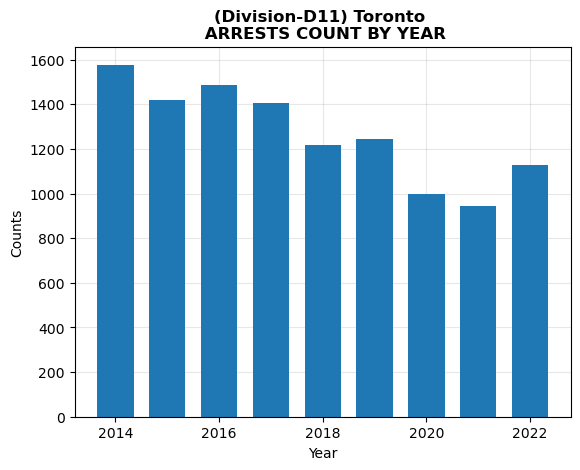

In [134]:
plotby_year_f(by_year,'arrest_count')

plt.savefig('arrest_by_year.pdf')
# write save command

In [135]:
def conditions_f(row):    
    if row["age_group"] == 'Adult':
        row['_adult'] = row['arrest_count']
        row['_youth'] = 0
    elif row["age_group"] == 'Youth':
        row['_adult'] = 0
        row['_youth'] = row['arrest_count']
    return row[['_adult','_youth']]

In [136]:
def by_year_age_f(data: pd.DataFrame) -> pd.DataFrame:

    # Group rows by year
    year_age_group = data.groupby(['arrest_year','age_group'])

    # Add up all Total Arrests for each year
    year_age_sum = year_age_group.agg(arrest_count = ('arrest_count', 'sum')).reset_index()

    # dropping unknown age_group
    year_age_sum = year_age_sum.drop(year_age_sum[year_age_sum['age_group'] == 'Unknown'].index)  

    # create columns '_adult', '_youth' based on 'age_group
    year_age_sum[['_adult','_youth']] = year_age_sum.apply(conditions_f, axis=1)

    # drop 'age_group' and 'arrest_count' because these values have been moved to '_adult','_youth'
    year_age_sum = year_age_sum.drop(['age_group', 'arrest_count'], axis=1)

    # group by year 
    year_age_group = year_age_sum.groupby(['arrest_year']).agg(adult=('_adult','sum'),
                                       youth=('_youth','sum')).reset_index()

    return year_age_group

In [137]:
def plotby_year_age_f(data,years):
    barWidth = 0.35

    # Set the position of the bars on the x-axis
    r1 = np.arange(len(data['adult']))
    r2 = [x + barWidth for x in r1]

    # Create the bar plots
    plt.bar(r1, data['adult'], color='blue', width=barWidth, edgecolor='white', label='Adult')
    plt.bar(r2, data['youth'], color='red', width=barWidth, edgecolor='white', label='Youth')

    # Add x-axis and y-axis labels and a title
    plt.xlabel('Year')
    plt.ylabel('Counts')
    plt.title('(Division-D11) Toronto \n ARRESTS COUNT BY YEAR', fontweight='bold')

    # Add x-axis tick labels for years
    plt.xticks([r + barWidth / 2 for r in range(len(data['adult']))], years)
    
    # Add legend
    plt.legend()

    plt.show()

In [138]:
year_age_df = by_year_age_f(total_df)
arrest_year=year_age_df['arrest_year']

In [139]:
#year_age_df
arrest_year

0    2014
1    2015
2    2016
3    2017
4    2018
5    2019
6    2020
7    2021
8    2022
Name: arrest_year, dtype: int64

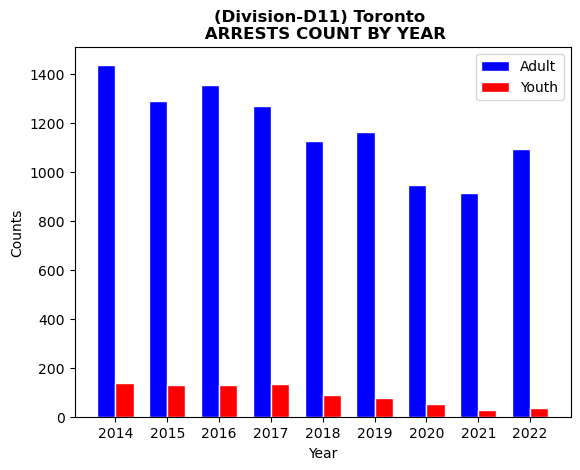

<Figure size 640x480 with 0 Axes>

In [140]:
plotby_year_age_f(year_age_df,arrest_year)
plt.savefig('arrest_by_year_age.pdf')
# write save command

In [141]:
def plot_by_year_age_cohort_f(annual_police_report):
    try:
        # Group the data by 'age_cohort' and 'arrest_year' and sum the 'arrest_count' for each group
        grouped_data = annual_police_report.groupby(['age_cohort', 'arrest_year'], observed=True)['arrest_count'].sum()

        # Create a dictionary to store subsets of data for each age cohort
        subset_dict = {}

        # Iterate through each group
        for (age_cohort, arrest_year), total_arrests in grouped_data.items():
            try:
                # Check if the age cohort already exists in the dictionary
                if age_cohort not in subset_dict:
                    # If not, create a new entry with an empty list
                    subset_dict[age_cohort] = []

                # Append the current group to the corresponding age cohort entry
                subset_dict[age_cohort].append((arrest_year, total_arrests))
            except Exception as e:
                print(f"An error occurred while processing group: {age_cohort}, {arrest_year}")
                print(e)

        # Plot each subset
        for age_cohort, subset_data in subset_dict.items():
            plt.plot([data[0] for data in subset_data], [data[1] for data in subset_data], label=age_cohort)

        # Add labels and legend
        plt.xlabel('Year')
        plt.ylabel('Total Arrests')
        plt.title('(Division-D11) Toronto \n ARRESTS COUNT BY YEAR AND AGE COHORT', fontweight='bold')
        plt.legend(title='AGE COHORT', bbox_to_anchor=(1, 1), loc='upper left')

        # Show the plot
        plt.show()
    except Exception as e:
        print("An error occurred during plot generation:")
        print(e)
    plt.savefig('arrest_by_year_age_cohort.pdf')

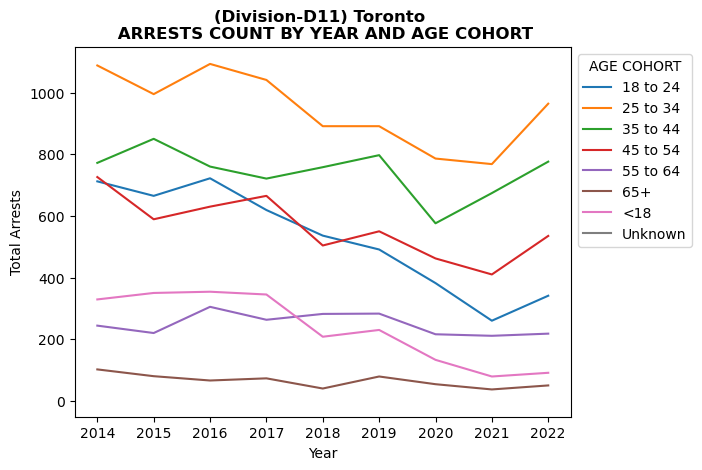

<Figure size 640x480 with 0 Axes>

In [142]:
plot_by_year_age_cohort_f(annual_police_report)


In [144]:
#Show a simple analysis, with mean, max, min for Arrest Year and Arrest Count columns

analysis_annual_police_report = annual_police_report.describe()

analysis_annual_police_reportROUNDED = analysis_annual_police_report.round()

analysis_annual_police_reportROUNDED

,_id,arrest_year,arrest_count
count,7621.0,7621.0,7621.0
mean,65129.0,2018.0,4.0
std,37649.0,3.0,6.0
min,17.0,2014.0,1.0
25%,32773.0,2016.0,1.0
50%,65441.0,2018.0,2.0
75%,97972.0,2020.0,4.0
max,129367.0,2022.0,69.0


In [145]:
# Use sklearn module to start predicting data and model

from sklearn.linear_model import LinearRegression

# Extracting the features (X) and the target variable (y)
X = annual_police_report[['arrest_year']]
y = annual_police_report['arrest_count']

# Initializing the linear regression model
model = LinearRegression()

# Fitting the model to your data
model.fit(X, y)

# Printing the intercept and coefficients
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_[0])



Intercept: 159.19398247049483
Coefficient: -0.07694898626673595


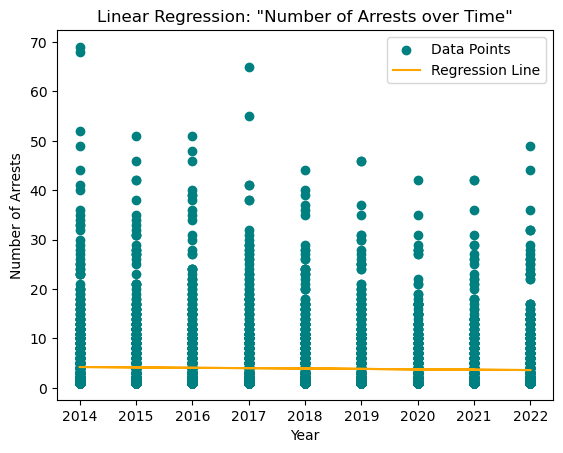

In [146]:
# This plotted Model predicts the crime rate using a linear relationship 
    # between number of arrests over time in Toronto from 2014 to 2022.

# Plotting the data points
plt.scatter(annual_police_report['arrest_year'], annual_police_report['arrest_count'], color='teal', label='Data Points')

# Plotting the regression line 
'''
Parameters
X : array-like or sparse matrix, shape (n_samples, n_features)
    Samples.

Returns
C : array, shape (n_samples,)
    Returns predicted values.
'''
plt.plot(annual_police_report['arrest_year'], model.predict(annual_police_report[['arrest_year']]), color='orange', label='Regression Line')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Number of Arrests')
plt.title('Linear Regression: "Number of Arrests over Time"')
plt.legend()

# Show the plot, with linear regression. 
plt.show()
